In [1]:
import deepxde as dde
from deepxde.backend import tf
import matplotlib.pyplot as plt
import numpy as np

2024-02-28 08:53:54.673980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def ide(x, y, int_mat):
    rhs = tf.matmul(int_mat, tf.slice(y, [0, 0], [int_mat.shape[1], y.shape[1]]))
    lhs1 = tf.gradients(y, x)[0]
    left = tf.slice(lhs1 + y, [0, 0], [rhs.shape[0], rhs.shape[1]])
    return left - rhs

def kernel(x, s):
    return np.exp(s - x)

def func(x):
    return np.exp(-x) * np.cosh(x)

In [3]:
geom = dde.geometry.TimeDomain(0, 5)
ic = dde.icbc.IC(geom, lambda x: 1, lambda _, on_initial: on_initial)

quad_deg = 20
data = dde.data.IDE(
    geom,
    ide,
    ic,
    quad_deg,
    kernel=kernel,
    num_domain=10,
    num_boundary=1,
    train_distribution="uniform",
)

In [4]:
layer_size = [1, 20, 20, 20, 1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("L-BFGS")
model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.057751 s

'compile' took 0.200733 s



/usr/local/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Training model...

Step      Train loss              Test loss               Test metric
0         [1.03e-01, 1.00e+00]    [1.03e-01, 0.00e+00]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 57
  Number of functions evaluations: 89
89        [5.29e-09, 5.68e-14]    [5.29e-09, 0.00e+00]    []  

Best model at step 89:
  train loss: 5.29e-09
  test loss: 5.29e-09
  test metric: []

'train' took 0.251894 s



(<deepxde.model.LossHistory at 0x1111b9cd0>,
 <deepxde.model.TrainState at 0x182da3550>)

In [5]:
X = geom.uniform_points(100)
y_true = func(X)
y_pred = model.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

L2 relative error: 0.0016857149


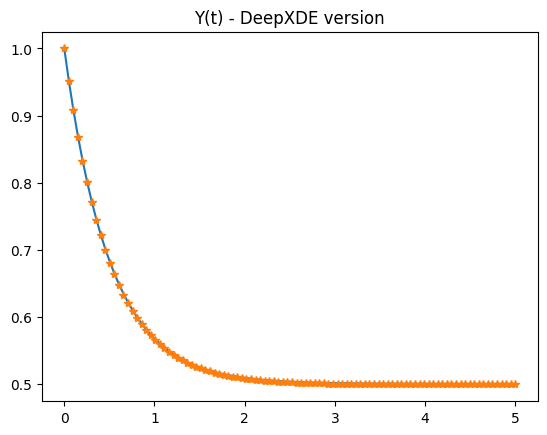

In [6]:
plt.title("Y(t) - DeepXDE version")
plt.plot(X, y_true)
plt.plot(X, y_pred, "*");